# Lab 2b: Model selection
## Dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

In [2]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

C:\Users\toell\AppData\Local\Temp\ipykernel_15300\2616928666.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array');


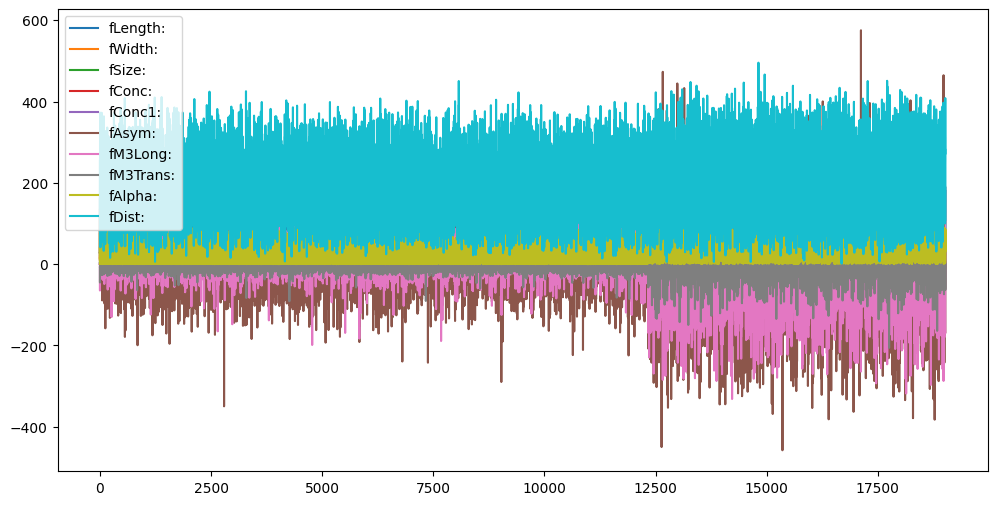

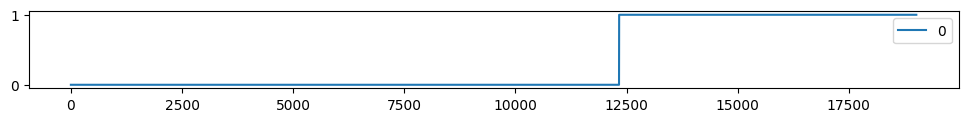

In [3]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

model_svm = SVC(kernel='rbf', C=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.75)

In [15]:
def train_model(model, X_train, y_train, scaler=None):
    X_train_scaled = scaler.fit_transform(X_train) if scaler is not None else X_train
    model.fit(X_train_scaled, y_train)
    return model

def asses_model(model, X, y):
    y_pred = model.predict(X)
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))

In [16]:
train_model(model_svm, X_train, y_train)
asses_model(model_svm, X_test, y_test)

[[2955  137]
 [ 690  973]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3092
           1       0.88      0.59      0.70      1663

    accuracy                           0.83      4755
   macro avg       0.84      0.77      0.79      4755
weighted avg       0.83      0.83      0.82      4755



## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [17]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

In [19]:
model_svm = SVC(kernel='rbf', C=1)
train_model(model_svm, Xs_train, y_train)
asses_model(model_svm, Xs_test, y_test)

[[2959  133]
 [ 488 1175]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3092
           1       0.90      0.71      0.79      1663

    accuracy                           0.87      4755
   macro avg       0.88      0.83      0.85      4755
weighted avg       0.87      0.87      0.87      4755



## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

Cs = np.logspace(-12, 12, num=1000, base=10)
gammas = np.logspace(-12, 12, num=1000, base=10)
param_grid = {'C': Cs, 'gamma' : gammas}
model_svm = SVC(kernel='rbf')

random_search = RandomizedSearchCV(
    model_svm, 
    param_distributions=param_grid, 
    n_iter=50, 
    n_jobs=4, 
    verbose=1,
    scoring='roc_auc'
    )
random_search.fit(Xs_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


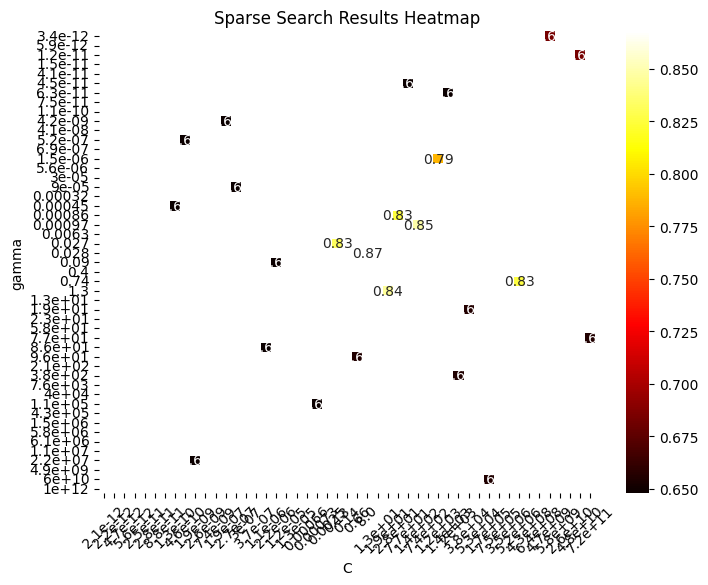

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sparse_heatmap(search, param_x, param_y, n_ticks=10, round_digits=3, annotate_fraction=0.5):
    params = search.cv_results_['params']
    scores = search.cv_results_['mean_test_score']
    
    # Extract unique values for param_x and param_y
    x_values = sorted(set(p[param_x] for p in params))
    y_values = sorted(set(p[param_y] for p in params))
    
    # Round values for readability
    x_labels = [f"{val:.2}" for val in x_values]
    y_labels = [f"{val:.2}" for val in y_values]
    
    # Create a mapping from param values to indices
    x_idx = {val: i for i, val in enumerate(x_values)}
    y_idx = {val: i for i, val in enumerate(y_values)}
    
    # Build the sparse score matrix
    score_matrix = np.full((len(y_values), len(x_values)), np.nan)
    for param, score in zip(params, scores):
        score_matrix[y_idx[param[param_y]], x_idx[param[param_x]]] = score
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        score_matrix, 
        xticklabels=x_labels, 
        yticklabels=y_labels, 
        annot=True, 
        cmap="hot", 
        fmt=".2",
        mask=np.random.rand(*score_matrix.shape) > annotate_fraction
        )
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title("Sparse Search Results Heatmap")
    plt.show()

plot_sparse_heatmap(random_search, 'C', 'gamma')

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, random_search.decision_function(Xs_test))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?